Blood cell Images-classifiction Model Inspiration

The diagnosis of blood-based diseases often involves identifying and characterizing patient blood samples. Automated methods to detect and classify blood cell subtypes have important medical applications.

In [1]:
import os
import torch
import torchvision
import pandas as pd
import torch.nn as nn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid

import torchvision.transforms as transforms
from torchvision.datasets.folder import default_loader
%matplotlib inline

In [2]:
project_name = 'Blood Cell Images'

Let us begin by downloading the data. We'll use the download_url function from PyTorch to get the data as a CSV (comma-separated values) le.

In [3]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

In [4]:
od.download('https://www.kaggle.com/paultimothymooney/blood-cells?select=dataset2-master')
{"username":"happyonu","key":"edf01f42daa4e56107289d727496c772"}

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: happyonu
Your Kaggle Key: ··········


  5%|▍         | 5.00M/108M [00:00<00:03, 32.2MB/s]

100%|██████████| 108M/108M [00:01<00:00, 80.6MB/s] 


{'key': 'edf01f42daa4e56107289d727496c772', 'username': 'happyonu'}

In [5]:
data_dir = './blood-cells'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/dataset2-master/dataset2-master/images/TRAIN")
print(classes)

['dataset-master', 'dataset2-master']
['NEUTROPHIL', 'EOSINOPHIL', 'MONOCYTE', 'LYMPHOCYTE']


In [6]:
import torchvision.transforms as tt

# stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
stats = ((0.4300, 0.4571, 0.4533), (0.2581, 0.2563, 0.2886))

train_tt = tt.Compose([
    tt.Resize((130, 130)),
    tt.RandomCrop(130, padding = 4, padding_mode = 'reflect'),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize(*stats, inplace = True)
])

val_tt = tt.Compose([
    tt.Resize((130, 130)),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

We can use the ImageFolder class from torchvision to load the data as PyTorch tensors.

In [7]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from PIL import Image


We can create training and validation datasets using the ImageFolder class from torchvision. In addition to the ToTensor transform, we'll also apply some other transforms to the images. There are a few important changes we'll make while creating PyTorch datasets for training and validation:
Channel-wise data normalization:

We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.
Randomized data augmentations:

We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.
Resizing the image:

The images in the dataset are of varying sizes with 3 channels. We have resized the image to 130 X 130 pixels.

In [8]:
train_set = ImageFolder(data_dir+'/dataset2-master/dataset2-master/images/TRAIN',train_tt)
val_set = ImageFolder(data_dir+'/dataset2-master/dataset2-master/images/TEST', val_tt)

print("Classes in dataset :", train_set.classes)
print("Classes in dataset :", val_set.classes)

Classes in dataset : ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
Classes in dataset : ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


In [9]:
batch_size = 128

In [10]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_set, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_set, batch_size*2, num_workers=2, pin_memory=True)

In [11]:
def denormalize(imgs, means, stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds  = torch.tensor(stds).reshape(1,3,1,1)
    return imgs * stds + means

def show_batch(dl):
    for imgs, labels in dl:
        print(imgs.shape)
        fig, ax = plt.subplots(figsize=(18,9))
        ax.set_xticks([])
        ax.set_yticks([])
        denorm_imgs = denormalize(imgs, *stats)
        plt.imshow(make_grid(denorm_imgs[:64], nrow=8).permute(1,2,0).clamp(0,1))
        break

torch.Size([128, 3, 130, 130])


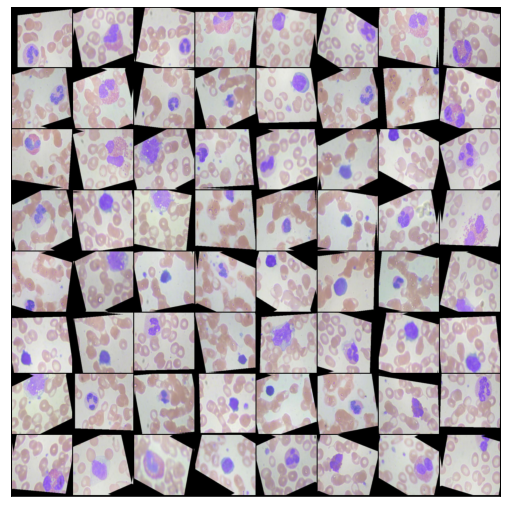

In [12]:
show_batch(train_dl)

To seamlessly use a GPU, if one is available, we define a couple of helper functions (get_default_device & to_device) and a helper class DeviceDataLoader to move our model & data to the GPU as required.

In [13]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (torch.device('cpu')) or a GPU (torch.device('cuda'))

In [14]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the GPU, and use to_device to move our model to the GPU.

In [15]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [16]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        imgs, labels = batch 
        out = self(imgs)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        imgs, labels = batch 
        out = self(imgs)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()

        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print(
            "Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
                epoch, result['lrs'][-1],
                result['train_loss'],
                result['val_loss'],
                result['val_acc']
            )
        )

In [17]:
def conv_block(in_c, out, pool=False):
    layers = [
        nn.Conv2d(in_c, out, kernel_size=3, padding=1),
        nn.BatchNorm2d(out),
        nn.ReLU(inplace=True)
    ]
    
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


class resnet9(ImageClassificationBase):
    def __init__(self, in_c, n_classes):
        super().__init__()
        
        # 3 x 130 x 130
        self.conv1 = conv_block(in_c, 64)  # 64 x 130 x 130
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 65 x 65
        self.res1 = nn.Sequential(
            conv_block(128, 128),
            conv_block(128, 128)        # 128 x 65 x 65
        )
        
        self.conv3 = conv_block(128, 256, pool=True) # 256 x 32 x 32
        self.conv4 = conv_block(256, 512, pool=True) # 512 x 16 x 16
        self.res2 = nn.Sequential(
            conv_block(512, 512),
            conv_block(512, 512)          # 512 x 16 x 16
        )
        
        self.classifier = nn.Sequential(
            nn.MaxPool2d(16),   
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(512, n_classes)
        )

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [18]:
print('No. Of Classes :', len(train_set.classes))

No. Of Classes : 4


In [19]:
model = to_device(resnet9(3, 6), device)
model

resnet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

Training the Model

Here we define 3 function "evaluate", "get_lr", "fit_one_cycle" to train the model using gradient descent and evaluate its performance on the validation set

In [34]:
@torch.no_grad()
def evaluate(model, val_dl):
    """ This function evaluated loss and accuracy on validation set """
    model.eval()
    outs = [model.validation_step(x) for x in val_dl]
    return model.validation_epoch_end(outs)

def get_lr(opt):
    """ Returns 'lr' for current epoch """
    for param_group in opt.param_groups:
        return param_group['lr']

def fit_one_cycle(num_epochs, max_lr, model, train_dl, val_dl,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    
    """ This is main function which deals with training model on our data """
    torch.cuda.empty_cache()
    history = []
    
    opt = opt_func(model.parameters(), max_lr, weight_decay = weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr, epochs=num_epochs,
                                               steps_per_epoch=len(train_dl))
    
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        lrs = []
        
        for batch in train_dl:
            # Training step
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            opt.step()
            opt.zero_grad()
            
            lrs.append(get_lr(opt))
            sched.step()
            
        # Validation step
        result = evaluate(model, val_dl)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch+1, result)
        history.append(result)
        
    return history

In [35]:
history = [evaluate(model, val_dl)]
history

[{'val_acc': 0.0, 'val_loss': 1.797164797782898}]

As Above result we can see Intial accurecy is around is 0%. which I am not expectecd. but I think model use randomly initial parameter.
We use the following hyperparmeter( epochs, learning rate no batch size) to train our model. For reaching higher accurecy we can see the acurrecy with change of parameter value.

In [64]:
# Setting metrics to be used

num_epochs = 10
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [65]:
history += fit_one_cycle(num_epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [1], last_lr: 0.00028, train_loss: 0.0205, val_loss: 1.1436, val_acc: 0.8422
Epoch [2], last_lr: 0.00076, train_loss: 0.1095, val_loss: 1.0033, val_acc: 0.8435
Epoch [3], last_lr: 0.00100, train_loss: 0.1061, val_loss: 0.5888, val_acc: 0.8442
Epoch [4], last_lr: 0.00095, train_loss: 0.0439, val_loss: 0.7820, val_acc: 0.8764
Epoch [5], last_lr: 0.00081, train_loss: 0.0259, val_loss: 1.3202, val_acc: 0.8507
Epoch [6], last_lr: 0.00061, train_loss: 0.0167, val_loss: 1.0265, val_acc: 0.8687
Epoch [7], last_lr: 0.00039, train_loss: 0.0044, val_loss: 1.1769, val_acc: 0.8820
Epoch [8], last_lr: 0.00019, train_loss: 0.0022, val_loss: 1.1689, val_acc: 0.8816
Epoch [9], last_lr: 0.00005, train_loss: 0.0011, val_loss: 1.2554, val_acc: 0.8829
Epoch [10], last_lr: 0.00000, train_loss: 0.0010, val_loss: 1.2635, val_acc: 0.8829


In [66]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

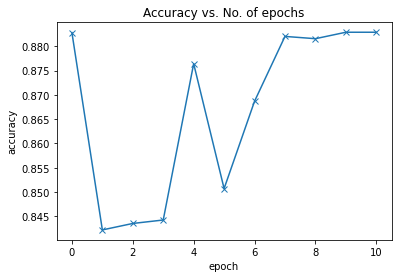

In [67]:
plot_accuracies(history)

In [68]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

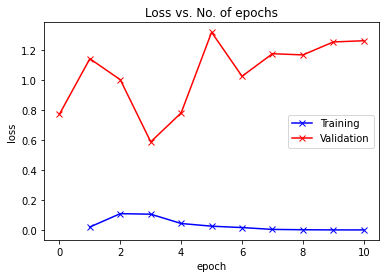

In [69]:
plot_losses(history)

In [70]:
test_dataset = ImageFolder(data_dir+'/dataset2-master/dataset2-master/images/TEST_SIMPLE', transform= val_tt)

In [71]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return test_dataset.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: EOSINOPHIL , Predicted: NEUTROPHIL


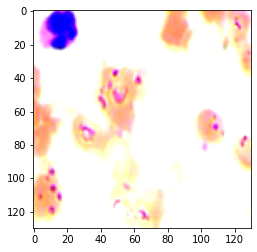

In [72]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: NEUTROPHIL , Predicted: NEUTROPHIL


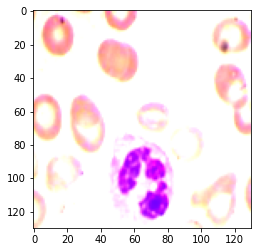

In [73]:
img, label = test_dataset[58]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))


In [74]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.8873239159584045, 'val_loss': 1.0422937870025635}

Now You can see accuracy of model 88.73%. 